# CMIP6 Arctic Case Study : Compute the aerosol-cloud interaction effective radiative forcing

--- 

## What this notebook holds :

---

<span style="color:red">**It is recommended to first run the *get_cmip6_data.ipynb* notebook to download and prepare the raw model's outputs data for the analysis.**</span>

This notebook aims at showing the effective radiative forcing that is caused by the aerosol burdens' levels of 2014 in the shortwabe. It aims at evaluating the different components of the aerosol-cloud's interaction impact on the Arctic warming. This is done using a subset of the CMIP6 model ensemble and using the APRP method devised by *Taylor and al. (2007)* and whose implementation was done by *Zelinka and al. (2023)*. 

The subset used is described in the github repository and is the one used by *Zelinka and al.*. It can be found in details in the *load_cmip6* submodule as the case described by *ZELINKA-SW* in the *set_search_criterias* function. 

### The use of CMIP6 data

We use two experiments realized during the CMIP6  : **piClim-control** and **piClim-aer**. These are both atmosphere-only climate model simulations in which sea surface temperatures (SSTs) and sea icea concentrations (SICs) are fixed at model-specific preindustrial climatological values. The description of the experiments can be found here : https://wcrp-cmip.github.io/CMIP6_CVs/docs/CMIP6_experiment_id.html. On the one hand, the **piClim-control** realization assumes aerosols burdens set to their preindustrial levels hence why it is dubbed as the control experiment. On the other hand, the **piClim-aer** realization uses present-day, present-day being 2014, aerosols burdens' levels.

The variable used are listed and explicited below according to : https://clipc-services.ceda.ac.uk/dreq/mipVars.html. All the variables are monthly timeseries over 30 years. We use the monthly climatology of each of these variables.

> <span style="color:SkyBlue">**clt**</span>  : Total cloud area fraction (%) for the whole atmospheric column
>
> <span style="color:gold">**rsdt**</span> : Shortwave radiation ($W/m^{2}$) **incident** at the TOA
> 
> <span style="color:orange">**rsut**</span> : Shortwave radiation ($W/m^{2}$) **going out**  at the TOA
>
> <span style="color:orangered">**rsutcs**</span> : Shortwave radiation ($W/m^{2}$) **going out**  at TOA for **clear-sky conditions**
> 
> <span style="color:Orchid">**rsds**</span> : Shortwave **downwelling** radiation ($W/m^{2}$) at the surface
> 
> <span style="color:Indigo ">**rsdscs**</span>  : Shortwave **downwelling** radiation ($W/m^{2}$) at the surface for **clear-sky conditions**
> 
> <span style="color:YellowGreen">**rsus**</span> : Shortwave **upwelling** radiation ($W/m^{2}$) at the surface
>
> <span style="color:Darkgreen">**rsuscs**</span>: Shortwave **upwelling** radiation ($W/m^{2}$) at the surface for **clear-sky conditions**
>
> **areacella** : For every grid, the latitude-dependent surface associated to each grid point.

### Approximate Partial Radiative Perturbation

**TO WRITE...**

## References : 

### APRP method

Taylor, K. E., M. Crucifix, P. Braconnot, C. D. Hewitt, C. Doutriaux, A. J. Broccoli, J. F. B. Mitchell, and M. J. Webb, 2007: Estimating Shortwave Radiative Forcing and Response in Climate Models. J. Climate, 20, 2530–2543, https://doi.org/10.1175/JCLI4143.1. 

### APRP module used for our analysis

https://github.com/mzelinka/aprp

Zelinka, M. D., Smith, C. J., Qin, Y., and Taylor, K. E.: Comparison of methods to estimate aerosol effective radiative forcings in climate models, Atmos. Chem. Phys., 23, 8879–8898, https://doi.org/10.5194/acp-23-8879-2023, 2023.

### Author

Giboni Lucas, 1st year PhD Candidate at IGE (CNRS), Grenoble.

https://github.com/gibonil/gibonil

### License

Feel free to share, use and improve the following code according to the provided license on the repository.

---

# Initialisation

---

## Importations

We import the needed libraries

In [ ]:
# ================ IMPORTATIONS ================ #

### LOAD AND NAVIGATE THROUGH THE DATA ###

import os  # to get access to commands related to path setting and creation of directories

### DATA OBJECTS AND ASSOCIATED COMPUTATION ###

import numpy as np  # to handle numpy arrays and the associated tools

import xarray as xr  # to manage the data

import xcdat as xc  # to handle climate model outputs with xarray

### REPRESENTING DATA ###

import matplotlib.pyplot as plt  # to handle plotting routines

import cartopy.crs as ccrs  # to handle map projections

### HOMEMADE LIBRARIES ###

## Load the climatology dictionary ##

from utilities.get_cmip6_data.store_data.dict_netcdf_transform import (
    netcdf_to_dict, # to load the climatology dictionary
)  

## Handle the climatology dictionary ##

from utilities.get_cmip6_data.prepare_data.extract_climatologies import (
    get_entries_only_from_clim_dict, # to extract the keys without the experiments,
    add_one_variable_to_dataset, # to add one variable to the full dataset
)

## Generate a common grid on which we will regrid all CMIP6 outputs ##

from utilities.tools_for_analysis.regridding.regridding_methods import(
    generate_the_common_coarse_grid, # to create the common coarse grid 
)

## Extract only one variant's model output ##

from utilities.tools_for_analysis.handle_data.extract_one_variant_per_model import (
    extract_only_one_variant_keys_list, # generates the keys' list with only one variant per source id
)

### APRP LIBRARY ###

from utilities.aprp.code.aprp import(
    APRP, # APRP method
)

### Define the paths for saving and loading data

In this part, the user needs to define the paths at which will be downloaded the data and saved the climatologies if necessary. They also need to define the path to the table associating the monthly climatologies netcdf files with their respective key in the climatologies' dictionary to be loaded. These paths are the absolute paths from the home directory.

If *get_cmip6_data.ipynb* notebook was run before, then only the path to the *key_paths_table.pkl* file is relevant here.

In [ ]:
# ================ DEFINE THE FOLDERS WHERE IS STORED THE DATA ================ #

### DEFINE THE HOME DIRECTORY ###

## Home directory ##

homedir_path = os.path.expanduser("~")

### DEFINE WHERE TO DOWNLOAD THE RAW DATA ###

## Parent directory of the download folder ##

parent_path_download = homedir_path + "/certainty-data"

## Name of the download folder ##

download_folder_name = "CMIP6-DATA"

### DEFINE WHERE TO SAVE THE CLIMATOLOGIES ###

## Path of the save directory ##

parent_path_save_clim = (
    homedir_path + "/certainty-data/" + download_folder_name + "/climatologies"
)

### DEFINE WHERE TO LOOK FOR THE TABLE OF THE CLIMATOLOGIES' PATHS ###

table_path = parent_path_save_clim + "/table" + "/key_paths_table.pkl"

## Load the CMIP6 climatology

We load the CMIP6 climatology. We first check the existence of the *key_paths_table.pkl* file that indicate that the *get_cmip6_data.ipynb* notebook was successfully run. Otherwise, we launch the full routine to download the raw data and generate the climatologies. 

**This full routine lasts about 2 hours if no download was done before.**

Sometimes the data cannot be found for the downloading phase even though the entry was found in the search phase... The user will need to relaunch the code as it is an error linked to the connection to the servers.

In [ ]:
# ================ LOAD THE MONTHLY CLIMATOLOGIES ================ #

### CHECK IF THE CLIMATOLOGIES WERE GENERATED BEFORE ###

if os.path.lexists(path = table_path) :

    ## The table exists we can therefore load the dictionary of the climatologies ## 

    print("The monthly climatologies were generated and can be retrieved.")

    data_cmip6_clim = netcdf_to_dict(parent_path_for_save = parent_path_save_clim)

else :

    ## The table does not exist : we need to download the data and prepare it ##

    print("No key_paths_table.pkl at the given path.\n" \
    "We download the data and create the monthly climatologies dictionary.")

    # We import the necessary submodule #

    from utilities.get_cmip6_data.prepare_data.extract_climatologies import (
    create_climatology_dict,  # to create the climatology dictionary and save it
    )

    ## Create the climatologies dictionary ##

    create_climatology_dict(
        data_path = parent_path_download,
        data_folder_name = download_folder_name,
        save_path = parent_path_save_clim,
        selected_case = "ZELINKA-SW",
        do_we_clear = True,
        verbose = False,
    )

    ## Load it ##

    data_cmip6_clim = netcdf_to_dict(parent_path_for_save = parent_path_save_clim)

## Apply the Approximate Partial Radiative Perturbation computation to our dictionary

### Generate the APRP dictionary

Before applying the APRP function we be able to call both the **control** and **aer** xarray datasets for a given entry. This is why we start by generating the list of the dictionary keys without the experiments.

In [ ]:
# ================ GET THE KEYS WITHOUT THE EXPERIMENT REFERENCE ================ #

### GENERATE THE KEYS WITHOUT THE EXPERIMENT ###

## Copy the list of the keys of the clim dictionary ##

clim_keys = list(data_cmip6_clim.keys())

## Generate the unique list of keys without the reference to the experiments ##

clim_keys_without_exp = [
    get_entries_only_from_clim_dict(key_with_exp) for key_with_exp in clim_keys
]

We apply the APRP method.

In [ ]:
dict_aprp = {}

for key in clim_keys_without_exp:

    key_control = key + ".piClim-control"

    key_aer = key + ".piClim-aer"

    data_cmip6_clim[key_control].load()

    data_cmip6_clim[key_aer].load()

    output = APRP(data_cmip6_clim[key_control], data_cmip6_clim[key_aer])

    dict_aprp[key] = output

In [ ]:
keys_list = list(dict_aprp.keys())

only_one_variant_keys_list = extract_only_one_variant_keys_list(keys_list = keys_list)

IN PROGRESS...

---

In [ ]:
def compute_world_avg_field(dataset : xr.Dataset, field : str) -> xr.Dataset:

    avg = dataset.spatial.average(field, axis=["X", "Y"])[field]

    return avg

In [ ]:
key_00 = list(keys_dict_aprp)[0]

key_00

In [ ]:
dict_aprp_time_avgd = {key : dict_aprp[key].mean("month")
                                               for key in keys_dict_aprp
                                               }


PROBLEM HERE !!!

In [ ]:
from tqdm import tqdm

keys_dict_aprp = dict_aprp.keys()


fields_to_be_avgd = [
    'cld',
    'sfc_alb',
    'sfc_alb_clr',
    'sfc_alb_oc',
    'noncld',
    'noncld_scat',
    'noncld_abs',
    'cld_amt',
    'cld_scat',
    'cld_abs'
    ]

# initialize

print("Initialize with one variable...\n")

field = "noncld"

# avg on cld NOT ENCESSARY 

dict_aprp_avgd = {key : compute_world_avg_field(dataset = dict_aprp_time_avgd[key],
                                               field = field,
                                               )
                                               for key in keys_dict_aprp
                                               }
"""
remaining_fields = fields_to_be_avgd[1:]

n_fields = len(remaining_fields)

for index in tqdm (range(n_fields), desc="Averaging all the variables..."):

    field = remaining_fields[index]

    # avg on field

    dict_aprp_avgd = {key : compute_world_avg_field(dataset = dict_aprp_avgd[key],
                                               field = field,
                                               )
                                               for key in keys_dict_aprp
                                               }
"""

In [ ]:
dict_aprp_avgd[key_00]

---

## Generate a common coarse grid to observe ensemble maps

---

### Creating a common coarse grid for all CMIP6 outputs

In order to be able to compare the different results, we wish to project them on a common map. This map needs to be coarser than all the natives grid in order to not generate false signals but still needs to be close enough to their original resolution. The solution that was found here is to generate the coarsest grid steps for latitude and longitude from the ensemble and generate a regular grid from them.

In [ ]:
common_coarse_grid = generate_the_common_coarse_grid(dict_aprp)

### Generate an extensive equivalent of the APRP datasets and regrid them onto a common grid 

from int to ext function. regridding function.


mieux écrire ces fonctions là c'est un peu le bordel

In [ ]:
def add_one_variable_to_dataset(
    variable_name: str,
    var_datarray,
    modify_data: bool = False,
    dataset: xr.Dataset = None,
    do_clim=False,
):
    """
    ### DEFINITION

    This function adds the variable_name variable to a xarray dataset with the var_datarray data array.
    If no datasets are provided, it will initialize them provided that modify_data is set to True.

    ### INPUTS

    VARIABLE_NAME : STR | variable to be added to the dataset

    VAR_DATARRAY : XARRAY DATA ARRAY | data array holding the variable variable_name to add to the xarray dataset

    MODIFY_DATA : BOOL | variable to say if we want to modify the input dataset

    DATASET : XARRAY DATASET | dataset without the new variable

    DO_CLIM : BOOL | bool defining if we compute the climatology or not by default set to True

    ### OUTPUTS

    DATASET : XARRAY DATASET | dataset with the new variable

    """

    ### PREPARE THE VARIABLE TO ADD ###

    ## Produce the climatology if needed ##

    if do_clim:

        var_to_add = var_datarray.temporal.climatology(
            variable_name, "month", weighted=True
        )  # we generate a monthly climatology

    ## Otherwise we just add the variable ##

    else:

        var_to_add = var_datarray

    ### ADDING THE VARIABLE TO THE DATASET ###

    ## Check wether we need to modify the dataset or not : if false initializes it / if true fills the provided ones ##

    if not modify_data:

        dataset = var_to_add

    else:

        dataset[variable_name] = (
            ("time", "lat", "lon"),
            var_to_add.data,
        )

    ### DIFFERENT CORRECTIONS ###

    ## Test that the cloud fractions are expressed as fraction and modify it ##

    if variable_name == "clt":

        # If not a fraction turn it into a fraction #

        if (
            np.mean(dataset["clt"]) > 1.0
        ):  # mean to consider the whole variable and not odd points
            dataset["clt"] = dataset["clt"] / 100.0

    return dataset


def intensive_field_to_extensive(dataset : xr.Dataset, areacella : xr.DataArray, intensive_field : str) -> xr.DataArray :
    """ modify in place a field from a dataset """

    ### EXTRACT THE FIELD VALUES ###

    var_array_intensive = dataset[intensive_field]
    
    ### INTENSIVE TO EXTENSIVE ###

    var_array_extensive = var_array_intensive * areacella
    
    return var_array_extensive

def extensive_field_to_intensive(dataset : xr.Dataset, areacella : xr.DataArray, extensive_field: str) ->  xr.DataArray:

    """ modify in place a field from a dataset """

    ### EXTRACT THE FIELD VALUES ###

    var_array_extensive = dataset[extensive_field]
    
    ### INTENSIVE TO EXTENSIVE ###

    var_array_intensive = var_array_extensive / areacella
    
    return var_array_intensive

def get_only_extensive_fields(all_fields : list[str], only_intensive_fields : list[str]) -> list[str]:
    """"""

    ### REMOVE THE INTENSIVE FIELDS OF THE FULL FIELDS LIST ###

    only_extensive_fields = [field for field in all_fields if field not in only_intensive_fields]

    return only_extensive_fields


def generate_dataset_with_only_the_extensive_fields(dataset : xr.Dataset, only_intensive_fields : list[str]) -> xr.Dataset:
    """"""

    ### GET ALL FIELDS OF THE DATASET ###

    all_fields =  list(dataset.keys())

    ### GENERATE ONLY THE EXTENSIVE FIELDS LIST ###

    only_extensive_fields = get_only_extensive_fields(all_fields = all_fields, only_intensive_fields = only_intensive_fields)

    ### GENERATE THE DATASET ###

    only_extensive_part_of_dataset = dataset[only_extensive_fields]

    return only_extensive_part_of_dataset

def partly_intensive_dataset_to_fully_extensive_dataset(dataset : xr.Dataset, intensive_fields_list : list[str]) -> xr.Dataset:
    """"""
    ### EXTRACT AREACELLA AND INITALIAZE A NEW FULLY EXTENSIVE DATAARRAY ###

    areacella_dataarray = dataset.areacella

    ### FULL LIST OF FIELDS ###

    all_fields = list(dataset.keys())

    ### GENERATE ONLY EXTENSIVE DATASET ###

    only_extensive_dataset = generate_dataset_with_only_the_extensive_fields(dataset = dataset, only_intensive_fields = intensive_fields_list)

    for intensive_field_name in intensive_fields_list :
        
        ### generate the extensive counterpart ###

        extensive_field = intensive_field_to_extensive(dataset = dataset, areacella = areacella_dataarray, intensive_field = intensive_field_name)

        ### new variable name ###

        extensive_field_name = intensive_field_name + "_extensive"

        ### add it to the only_extensive_dataset ###

        only_extensive_dataset = add_one_variable_to_dataset(variable_name = extensive_field_name, 
                                                             var_datarray = extensive_field, 
                                                             modify_data = True, 
                                                             dataset = only_extensive_dataset,
                                                             )
    return only_extensive_dataset

def fully_extensive_dataset_to_partly_intensive_dataset(dataset : xr.Dataset, intensive_fields_list : list[str]) -> xr.Dataset:
    
    ### EXTRACT AREACELLA AND INITALIAZE A NEW FULLY EXTENSIVE DATAARRAY ###

    areacella_dataarray = dataset.areacella

    ### FULL LIST OF FIELDS ###

    all_fields = list(dataset.keys())

    ### TO BE TRANSFORMED VARIABLES ###

    fields_to_bet_transformed_name_list = [field + "_extensive" for field in intensive_fields_list]

    ### GENERATE THE NEW DATASET WITH INTENSIVE FIELDS ###

    partly_intensive_dataset = generate_dataset_with_only_the_extensive_fields(dataset = dataset, only_intensive_fields = fields_to_bet_transformed_name_list)

    for intensive_field_name in intensive_fields_list :

        extensive_field_to_return_intensive_name = intensive_field_name + "_extensive"
    
        ### go back to intensive  ###

        intensive_field = extensive_field_to_intensive(dataset = dataset, areacella = areacella_dataarray, extensive_field = extensive_field_to_return_intensive_name)
        
        ### add it to the only_extensive_dataset ###

        partly_intensive_dataset = add_one_variable_to_dataset(variable_name = intensive_field_name, 
                                                             var_datarray = intensive_field, 
                                                             modify_data = True, 
                                                             dataset = partly_intensive_dataset,
                                                             )
    return partly_intensive_dataset

In [ ]:
def compute_world_avg(dataset : xr.Dataset, areacella : xr.DataArray, intensive_field : str) -> xr.DataArray :
    """ modify in place a field from a dataset """

    ### EXTRACT THE FIELD VALUES ###

    var_array_intensive = dataset[intensive_field]
    
    ### INTENSIVE TO EXTENSIVE ###

    var_array_extensive = var_array_intensive * areacella
    
    return var_array_extensive

In [ ]:
from numpy.typing import NDArray

def compute_grid_areacella(grid : xr.Dataset) -> NDArray[np.float64] :
    """
    """
    ### INITIALIZATION ###

    ## Define the radius of the earth ##
    
    R_earth = 6371.0 * 10**3

    ## Define the lat and lon arrays ##

    latitude = grid.lat

    longitude = grid.lon

    ## Define the steps in radians ##

    # In degreees #

    dlon = np.mean(np.diff(longitude))

    dlat = np.mean(np.diff(latitude))

    # In rad #
    
    dlon_rad = np.deg2rad(dlon)
    
    dlat_rad = np.deg2rad(dlat)

    print(dlon, dlat)

    ## Define the shape of the grid ##

    n_lat = grid.lat.size

    n_lon = grid.lon.size

    ### COMPUTATION OF AREACELLA FOR ONE MODEL ###

    ## Definition ##
    
    areacella = np.zeros((n_lat,n_lon))

    ## Cycle for ##
    
    for ii_lat,lat in enumerate(latitude):

        for ii_lon,lon in enumerate(longitude):

            areacella[ii_lat,ii_lon] = (R_earth*dlat_rad)*(R_earth*np.cos(np.deg2rad(lat))*dlon_rad)

    return areacella

In [ ]:
key_00 = list(dict_aprp.keys())[0]

ds = dict_aprp[key_00]

intensive_fields_list = [
    "cld",
    "sfc_alb",
    "sfc_alb_clr",
    "sfc_alb_oc",
    "noncld",
    "noncld_scat",
    "noncld_abs",
    "cld_amt",
    "cld_scat",
    "cld_abs",
]

only_extensive_dataset = partly_intensive_dataset_to_fully_extensive_dataset(dataset = ds,
                                                                             intensive_fields_list = intensive_fields_list,
                                                                             )


### Finally compute the regridded APRP values by dividing by the new grid points areacella

code an areacella function. code a from extensive to intensive function

If performing conservative regridding from a high/medium resolution lat/lon grid to a coarse lat/lon target, Regrid2 may provide better results as it assumes grid cells with constant latitudes and longitudes while xESMF assumes the cells are connected by Great Circles : https://xcdat.readthedocs.io/en/latest/generated/xarray.Dataset.regridder.horizontal.html


BASE ARRAY NO VALUE AT THE POLES ??? 

In [ ]:
output = ds.regridder.horizontal("sfc_alb", common_coarse_grid, tool="regrid2")

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ds.sfc_alb.isel(time=0).plot(
    ax=axes[0], vmin=-40, vmax=40, extend="both", cmap="RdBu_r"
)

output.sfc_alb.isel(time=0).plot(
    ax=axes[1], vmin=-40, vmax=40, extend="both", cmap="RdBu_r"
)
axes[1].set_title("Output data")

plt.tight_layout()

extraire une même variable, regrid toute la variable et combiner sur le nb de modèles.


In [ ]:
def regrid_field(dataset : xr.Dataset, field: str, output_grid : xr.Dataset):
    """ """

    field_regridded = dataset.regridder.horizontal(field, output_grid, tool="regrid2")

    return field_regridded

In [ ]:
keys_dict_aprp = dict_aprp.keys()

intensive_fields_list = [
    "cld",
    "sfc_alb",
    "sfc_alb_clr",
    "sfc_alb_oc",
    "noncld",
    "noncld_scat",
    "noncld_abs",
    "cld_amt",
    "cld_scat",
    "cld_abs",
]

dict_aprp_fully_extensive = {key : partly_intensive_dataset_to_fully_extensive_dataset(dataset = dict_aprp[key],
                                                                                       intensive_fields_list = intensive_fields_list,
                                                                                       )
                                                                                       for key in keys_dict_aprp
                                                                                       }

In [ ]:
from tqdm import tqdm

keys_dict_aprp = dict_aprp.keys()


fields_to_be_regridded = [
    'cld_extensive',
    'sfc_alb_extensive',
    'sfc_alb_clr_extensive',
    'sfc_alb_oc_extensive',
    'noncld_extensive',
    'noncld_scat_extensive',
    'noncld_abs_extensive',
    'cld_amt_extensive',
    'cld_scat_extensive',
    'cld_abs_extensive'
    ]

# initialize

print("Initialize with one variable...\n")

field = "cld_extensive"

dict_aprp_regridded_full = {key : regrid_field(dataset = dict_aprp_fully_extensive[key],
                                               field = field,
                                               output_grid = common_coarse_grid
                                               )
                                               for key in keys_dict_aprp
                                               }

remaining_fields = fields_to_be_regridded[1:]
n_fields = len(remaining_fields)

for index in tqdm (range(n_fields), desc="Regridding all the variables...\n"):

    field = remaining_fields[index]
    # generate the dictionnary of all models for one field

    dict_aprp_regridded_given_field = {key : regrid_field(dataset = dict_aprp_fully_extensive[key],
                                               field = field,
                                               output_grid = common_coarse_grid
                                               )
                                               for key in keys_dict_aprp
                                               }

    # add this one field to the full dictionnary

    dict_aprp_regridded_full = {
        key: add_one_variable_to_dataset(
            variable_name=field,
            var_datarray=dict_aprp_regridded_given_field[key][field],
            modify_data=True,
            dataset=dict_aprp_regridded_full[key],
        )
        for key in keys_dict_aprp
    }


output_areacella = compute_grid_areacella(common_coarse_grid)

### ADD AREACELLA ###

print("Add areacella...\n")

for key in keys_dict_aprp :

    dataset_given_exp = dict_aprp_regridded_full[key]

    dataset_given_exp["areacella"] = (
            ("lat", "lon"),
            output_areacella,
        )
    
    dict_aprp_regridded_full[key] = dataset_given_exp

without intensive transition...

In [ ]:
from tqdm import tqdm

keys_dict_aprp = dict_aprp.keys()


fields_to_be_regridded = [
    'cld',
    'sfc_alb',
    'sfc_alb_clr',
    'sfc_alb_oc',
    'noncld',
    'noncld_scat',
    'noncld_abs',
    'cld_amt',
    'cld_scat',
    'cld_abs'
    ]

# initialize

print("Initialize with one variable...\n")

field = "cld"

dict_aprp_regridded = {key : regrid_field(dataset = dict_aprp[key],
                                               field = field,
                                               output_grid = common_coarse_grid
                                               )
                                               for key in keys_dict_aprp
                                               }

remaining_fields = fields_to_be_regridded[1:]
n_fields = len(remaining_fields)

for index in tqdm (range(n_fields), desc="Regridding all the variables..."):

    field = remaining_fields[index]
    # generate the dictionnary of all models for one field

    dict_aprp_regridded_given_field = {key : regrid_field(dataset = dict_aprp[key],
                                               field = field,
                                               output_grid = common_coarse_grid
                                               )
                                               for key in keys_dict_aprp
                                               }

    # add this one field to the full dictionnary

    dict_aprp_regridded = {
        key: add_one_variable_to_dataset(
            variable_name=field,
            var_datarray=dict_aprp_regridded_given_field[key][field],
            modify_data=True,
            dataset=dict_aprp_regridded[key],
        )
        for key in keys_dict_aprp
    }


output_areacella = compute_grid_areacella(common_coarse_grid)

### ADD AREACELLA ###

print("Add areacella...\n")

for key in keys_dict_aprp :

    dataset_given_exp = dict_aprp_regridded[key]

    dataset_given_exp["areacella"] = (
            ("lat", "lon"),
            output_areacella,
        )
    
    dict_aprp_regridded[key] = dataset_given_exp

In [ ]:
keys_dict_aprp = dict_aprp.keys()

intensive_fields_list = [
    "cld",
    "sfc_alb",
    "sfc_alb_clr",
    "sfc_alb_oc",
    "noncld",
    "noncld_scat",
    "noncld_abs",
    "cld_amt",
    "cld_scat",
    "cld_abs",
]


dict_aprp_regridded_full_intensive = {key : fully_extensive_dataset_to_partly_intensive_dataset(dataset = dict_aprp_regridded_full[key],
                                                                                       intensive_fields_list = intensive_fields_list,
                                                                                       )
                                                                                       for key in keys_dict_aprp
                                                                                       }

In [ ]:
# needed for the concat function to work

dict_aprp_regridded_full_intensive = {
    key: dict_aprp_regridded_full_intensive[key]
    .groupby(dict_aprp_regridded_full_intensive[key].time.dt.month)
    .mean()
    for key in keys_dict_aprp
}

In [67]:
dict_aprp_regridded_full_intensive_selected = {key : dict_aprp_regridded_full_intensive[key] for key in only_one_variant_keys_list}

In [68]:
# let's make the entry average

ensemble_aprp_avg = xr.concat(dict_aprp_regridded_full_intensive_selected.values(), "entry").mean(
    dim="entry"
)

## PLOT MAP OF APRP COMPONENTS

In [69]:
ensemble_aprp_avg

<xarray.Dataset> Size: 9MB
Dimensions:      (month: 12, lon: 128, bnds: 2, lat: 64)
Coordinates:
  * lat          (lat) float64 512B -88.59 -85.78 -82.97 ... 82.97 85.78 88.59
  * lon          (lon) float64 1kB 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: bnds
Data variables: (12/13)
    lon_bnds     (month, lon, bnds) float64 25kB -1.406 1.406 ... 355.8 358.6
    lat_bnds     (month, lat, bnds) float64 12kB -90.0 -87.19 ... 87.19 90.0
    areacella    (month, lat, lon) float64 786kB 2.4e+09 2.4e+09 ... 2.4e+09
    cld          (month, lat, lon) float64 786kB 0.01032 0.01251 ... 0.0 0.0
    sfc_alb      (month, lat, lon) float64 786kB -0.09556 -0.0969 ... 0.0 0.0
    sfc_alb_clr  (month, lat, lon) float64 786kB -0.06148 -0.05964 ... 0.0 0.0
    ...           ...
    noncld       (month, lat, lon) float64 786kB 0.1331 0.1329 ... 0.0 0.0
    noncld_scat  (month, lat, lon) float64 786kB 0.006425 0.006699 ... 0.0 0.0
    noncld_abs   (month, lat, lon) float64 786kB 0.1267 0.1262 ... 0.0 0.0
    cld_amt      (month, lat, lon) float64 786kB 0.009722 0.01293 ... 0.0 0.0
    cld_scat     (month, lat, lon) float64 786kB 0.0003133 -0.005663 ... 0.0 0.0
    cld_abs      (month, lat, lon) float64 786kB 0.0002817 0.005242 ... 0.0 0.0

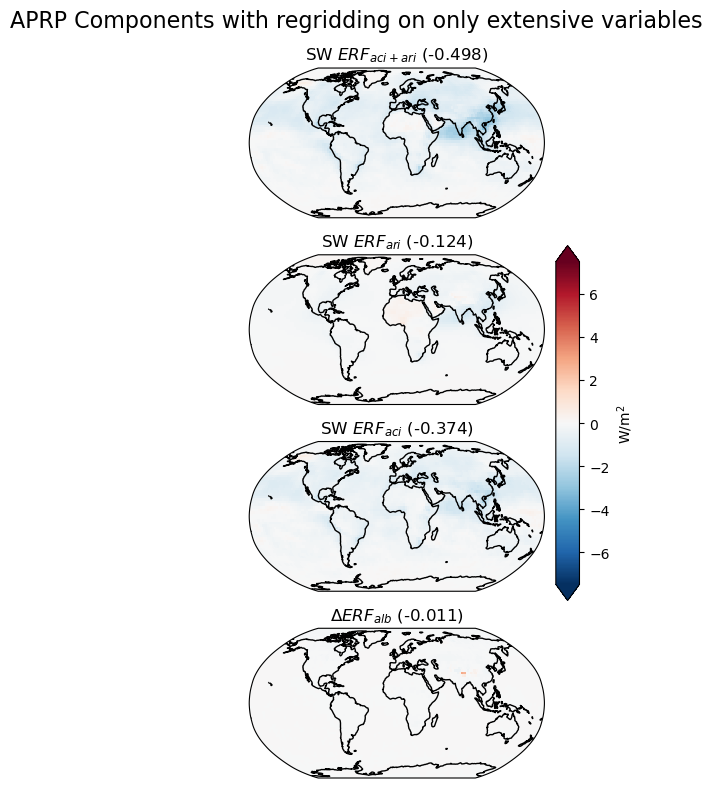

In [70]:
output = ensemble_aprp_avg

fig = plt.figure(figsize = (6,8))
plt.suptitle("APRP Components with regridding on only extensive variables", fontsize=16)
axes = fig.subplots(nrows= 4, ncols = 1, subplot_kw={"projection": ccrs.Robinson()})
cnt = -1

avgmap = output.mean("month")

plot_list_avg = [
    (avgmap.spatial.average("cld", axis=["X", "Y"])["cld"] + avgmap.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI + ACI
    (avgmap.spatial.average("noncld", axis=["X", "Y"])["noncld"]).values, # SW ERF ARI
    (avgmap.spatial.average("cld", axis=["X", "Y"])["cld"]).values, # SW ERF ACI
    (avgmap.spatial.average("sfc_alb", axis=["X", "Y"])["sfc_alb"]).values, # DELTA ALBED SURF
]

plot_list_map = [
    (avgmap["cld"] + avgmap["noncld"]), # SW ERF ARI + ACI
    (avgmap["noncld"]), # SW ERF ARI
    (avgmap["cld"]), # SW ERF ACI
    (avgmap["sfc_alb"]), # DELTA ALBED SURF
]

list_titles = [
        "SW $ERF_{aci + ari}$",
        "SW $ERF_{ari}$",
        "SW $ERF_{aci}$",
        "$\\Delta ERF_{alb}$"
]
for row in range(4):
        
        cnt += 1

        avg = plot_list_avg[cnt]

        pl = plot_list_map[cnt].plot(
            ax=axes[row],
            transform=ccrs.PlateCarree(),
            vmin=-7.5,
            vmax=7.5,
            cmap="RdBu_r",
            add_colorbar=False,
        )
        axes[row].set_title(list_titles[cnt] + " (" + str(np.round(avg,3)) + ")")

        axes[row].coastlines()

plt.tight_layout()

fig.colorbar(
    pl, ax=axes.ravel().tolist(), pad=0.02, shrink=0.5, aspect=15, label="W/m$^2$", extend='both'
)